In [68]:
from random import random
import generators as gen
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from math import pi, log, sin

#TIEMPOS DE ARRIBO
def lamda_t(t):
    return 30 + 30 * np.sin((2 * np.pi * t) / 24)
    
def Poisson_NH(T):
    NT = 0
    Eventos = []
    lamda = 60
    t = -log(1 - random()) / lamda
    while t <= T:
        V = random()
        if V < lamda_t(t) / lamda:
            NT += 1
            Eventos.append(t)
        t += -log(1 - random()) / lamda
    return NT, Eventos

def exp(lamda):
    u =  random()
    return -log(u)/lamda

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def pdf(x):
    x = np.asarray(x, dtype = float)
    return np.piecewise(
        x,
        [x < 0, (0 <= x) & (x <= 48), x > 48],
        [0, lambda x: lamda_t(x), 0]
    )


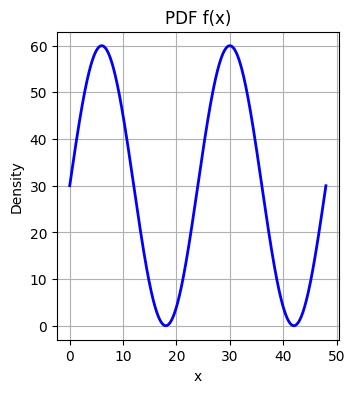

In [36]:
# Generate x values
x = np.linspace(0, 48, 1000) #Esto crea un array x con 1000 valores equiespaciados entre 0 y 8.

# Crea una figura con un tamaño de 8 pulgadas de ancho por 4 de alto
plt.figure(figsize=(8, 4))

# Plot PDF
plt.subplot(1, 2, 1)
#divide la figura en 1 fila y 2 columnas, y activa el primer panel (izquierdo) para graficar la PDF.
plt.plot(x, pdf(x), 'b-', linewidth=2)
#Se evalúa pdf(x) para todos los valores de x generados y se grafica como una línea azul ('b-') con grosor 2.
plt.title('PDF f(x)')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)

In [38]:
def queueSystem(hours=48):
    n, arribos =  Poisson_NH(hours)
    servicios = [exp(40) for _ in arribos]
    esperas = []
    uso = [[0,0]]
    tamaño_cola = [[0,0]]
    queue = []
    arriboAnt = 0
    
    for i in range(n):
        inicio = max(arribos[i], arriboAnt)
        espera = inicio - arribos[i]
        esperas.append(espera)
        if espera != 0:
            uso[-1][1] += servicios[i]
        else:
            uso.append([inicio, inicio + servicios[i]])
       
        arriboAnt = inicio + servicios[i]
        
        queue.append(arriboAnt)
        while queue[0] < arribos[i]:
            queue.pop(0)   
        
        tamaño_cola.append([arribos[i], len(queue)])
                    
    return arribos, servicios, esperas, uso, tamaño_cola

arribos, servicios, esperas, uso, tamaño_cola = queueSystem()

In [39]:
##Tasa de Utilizacion del servicio.
def tasa_servicio(usos, horas=48):
    tasa = [0.0] * horas
    for uso in usos:
        inicio, fin = uso
        h_ini = int(np.floor(inicio))
        h_fin = int(np.floor(fin))
        
        # Asegurar que el servicio solo se considere dentro del rango de horas
        for h in range(max(h_ini, 0), min(h_fin + 1, horas)):
            comienzo = max(inicio, h)
            termino = min(fin, h + 1)
            if termino > comienzo:
                tasa[h] += termino - comienzo
    return tasa


#Porcentaje de tiempo del servido ocupado
def uso_total_servicio(tasa):
    total = 0
    for t in tasa:
        total += t
    return total / 48

def promedio_tasa(Nsim):
    tasa_est = [0]*48
    for _ in range(Nsim):
        arribos, servicios, esperas, uso, cola = queueSystem()
        tasa = tasa_servicio(uso)
        for i in range(48):
            tasa_est[i] += tasa[i]
            
    for i in range(48):
        tasa_est[i] = tasa_est[i] / Nsim 
    return tasa_est

def promedio_uso(Nsim):
    r = 0
    for _ in range(Nsim):
        arribos, servicios, esperas, uso, cola = queueSystem()
        tasa = tasa_servicio(uso)
        procentaje = uso_total_servicio(tasa)

        r += procentaje
    return r / Nsim
         

In [41]:
tasa_prom = promedio_tasa(1000) 

tasa = np.array(tasa_prom)
horas = np.arange(48)
personas_en_fila = cola[:, 1]
plt.plot(horas, personas_en_fila, 'b-', linewidth=2)
plt.title('Número de personas en la fila a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Personas en fila')
plt.grid(True)
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [42]:
# TIempo promedio de cliente en sistema

_, servicios, _, _, _ = queueSystem() 
def est_mean(tiempos): ##EN horas es aprox 0.02499.., equivale a 90 seg.
    r = 0
    for t in tiempos:
        r += t
    return r / len(tiempos)

est_mean(servicios)

0.0238591330805377

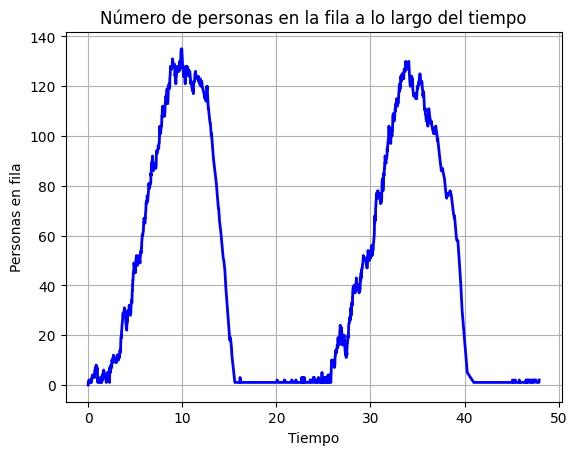

In [50]:
## Cola
_, _, _, _, cola = queueSystem()

cola = np.array(cola)
tiempos = cola[:, 0]
personas_en_fila = cola[:, 1]
plt.plot(tiempos, personas_en_fila, 'b-', linewidth=2)
plt.title('Número de personas en la fila a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Personas en fila')
plt.grid(True)
plt.show()


In [ ]:
"""
QUEDA PENDIENTE:
    -Distribucion de timepos de espera y Histogramas.
    -Dsitribucion de timepo entre arribos
    -Distribucion de servicios
--> Hay que usar la distribucion empirica para obtenerlas.
"""

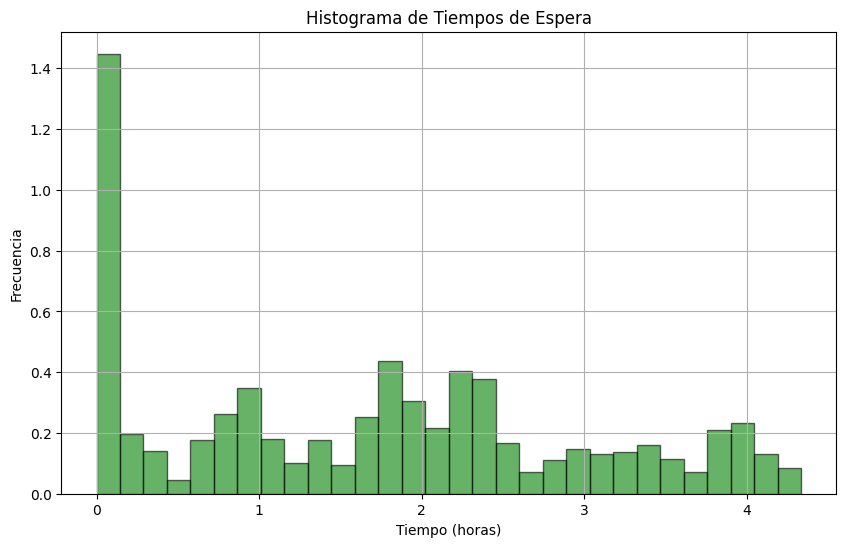

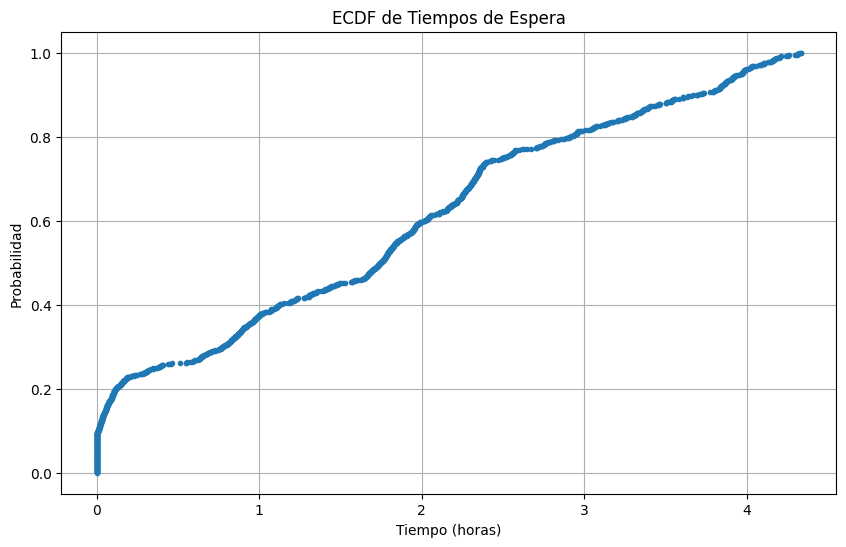

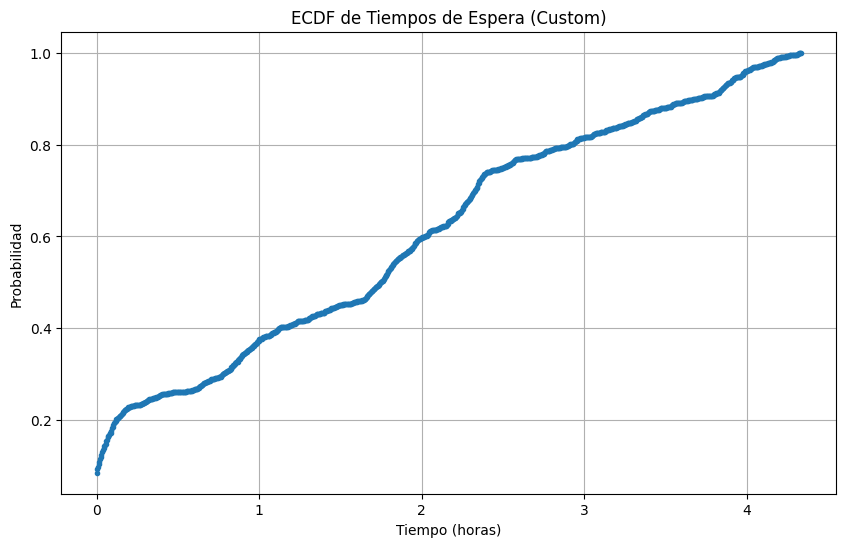

In [71]:
def ecdf(datos, N):
    datos = sorted(datos)
    n = len(datos)
    x = np.linspace(min(datos), max(datos), N)
    y = np.zeros(N)
    
    for i in range(N):
        y[i] = sum(1 for d in datos if d <= x[i]) / n
    
    return x, y



def plot_histogram(data, title, xlabel, ylabel, bins=30):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, density=True, alpha=0.6, color='g', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

"""Se utiliza statsmodels para graficar la CDF de los tiempos de espera"""
def plot_cdf(data, title, xlabel, ylabel):
    x, y = ECDF(data).x, ECDF(data).y
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='.', linestyle='none')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


""" Función para graficar la CDF usando la función ecdf definida anteriormente sólo para comparar """
def plot_cdf2(data, title, xlabel, ylabel):
    x, y = ecdf(data, 1000)
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='.', linestyle='none')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Graficar histogramas y CDFs
plot_histogram(esperas, 'Histograma de Tiempos de Espera', 'Tiempo (horas)', 'Frecuencia')
plot_cdf(esperas, 'ECDF de Tiempos de Espera', 'Tiempo (horas)', 'Probabilidad')
plot_cdf2(esperas, 'ECDF de Tiempos de Espera (Custom)', 'Tiempo (horas)', 'Probabilidad')